In [1]:
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
from sklearn.model_selection import train_test_split
from PIL import Image
import os

dataset_path = './dataset/UTKFace/'
file_list = os.listdir(dataset_path)

ages = [int(file.split('_')[0]) for file in file_list]
genders = [int(file.split('_')[1]) for file in file_list]  # 0 for Male, 1 for Female
df = pd.DataFrame({'filename': file_list, 'age': ages, 'gender': genders})

proj_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df, val_df = train_test_split(proj_df, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Ridimensiona le immagini a 64x64
    transforms.ToTensor(),         # Converte le immagini in tensori
])

class UTKFaceDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        age = self.dataframe.iloc[idx, 1]
        gender = self.dataframe.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)

        return image, gender, age

# Crea istanze del dataset per addestramento e test
train_dataset = UTKFaceDataset(dataframe=train_df, root_dir=dataset_path, transform=transform)
val_dataset = UTKFaceDataset(dataframe=val_df, root_dir=dataset_path, transform=transform)
test_dataset = UTKFaceDataset(dataframe=test_df, root_dir=dataset_path, transform=transform)

# Crea DataLoader per iterare sui dati durante l'addestramento
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class GenderAgeClassifier(nn.Module):
    def __init__(self):
        super(GenderAgeClassifier, self).__init__()

        # CNN architecture
        self.shared_cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Dimensione dell'output dopo le CNN

        # Branca per il genere
        self.gender_fc1 = nn.Linear(2048, 128)
        self.gender_fc2 = nn.Linear(128, 2)  # 2 classi per il genere (maschio o femmina)

        # Branca per l'età
        self.age_fc1 = nn.Linear(2048, 128)
        self.age_fc2 = nn.Linear(128, 1)  # 1 output per l'età (regressione)

    def forward(self, x):
        # Implementa la logica di propagazione in avanti
        cnn_output = self.shared_cnn(x)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)

        #print("Dimensione di cnn_output:", cnn_output.size())

        # Branca per il genere
        #print("Dimensione di gender_fc1 weight:", self.gender_fc1.weight.size())
        #print("Dimensione di gender_fc1 bias:", self.gender_fc1.bias.size())
        gender_output = F.relu(self.gender_fc1(cnn_output))
        #print("Dimensione di gender_output:", gender_output.size())
        gender_output = self.gender_fc2(gender_output)

        # Branca per l'età
        #print("Dimensione di age_fc1 weight:", self.age_fc1.weight.size())
        #print("Dimensione di age_fc1 bias:", self.age_fc1.bias.size())
        age_output = F.relu(self.age_fc1(cnn_output))
        #print("Dimensione di age_output:", age_output.size())
        age_output = self.age_fc2(age_output)

        return gender_output, age_output


# Inizializza il modello
model = GenderAgeClassifier()

In [4]:
criterion_gender = nn.CrossEntropyLoss()
criterion_age = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
from sklearn.metrics import r2_score

# Numero massimo di epoche di addestramento
num_epochs = 20

# Liste per salvare l'andamento della perdita
train_loss_list = []
val_loss_list = []

# Liste per salvare l'andamento dell'accuratezza
train_gender_accuracy_list = []
val_gender_accuracy_list = []
train_age_accuracy_list = []
val_age_accuracy_list = []

if torch.cuda.is_available():
    model = model.cuda()

# Addestramento del modello
for epoch in range(num_epochs):
    model.train()
    
    correct_gender_train = 0
    total_train = 0
    train_age_r2 = 0
    
    for inputs, gender_labels, age_labels in train_loader:
        age_labels = age_labels.float().view(-1, 1)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            gender_labels = gender_labels.cuda()
            age_labels = age_labels.cuda()
        optimizer.zero_grad()
        gender_output, age_output = model(inputs)
        
        # Sposta l'output alla stessa device di gender_labels
        gender_output = gender_output.to(gender_labels.device)
        age_output = age_output.to(age_labels.device)

        # Calcola le perdite per entrambe le attività
        gender_loss = criterion_gender(gender_output, gender_labels)
        age_loss = criterion_age(age_output, age_labels)
        
        # Calcola la perdita totale
        total_loss = gender_loss + age_loss
        
        # Esegui la retropropagazione e l'aggiornamento dei pesi
        total_loss.backward()
        optimizer.step()

        train_loss_list.append(total_loss.item())
        
        # Calcola l'accuratezza per il genere
        _, predicted_gender = torch.max(gender_output, 1)
        correct_gender_train += (predicted_gender == gender_labels).sum().item()
        total_train += gender_labels.size(0)

        # Calcola l'R2 score per l'età
        predicted_age = age_output.detach().cpu().numpy()
        train_age_r2 += r2_score(age_labels.cpu().numpy(), predicted_age)

    train_gender_accuracy = correct_gender_train / total_train
    train_age_r2 /= len(train_loader)
        
    # Valuta il modello sul set di val
    model.eval()
    with torch.no_grad():
        
        correct_gender_val = 0
        total_val = 0
        val_age_r2 = 0
        
        val_loss_gender = 0.0
        val_loss_age = 0.0
        total_samples = 0

        for inputs, gender_labels, age_labels in val_loader:
            age_labels = age_labels.float().view(-1, 1)
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                gender_labels = gender_labels.cuda()
                age_labels = age_labels.cuda()
            gender_output, age_output = model(inputs)

            # Sposta l'output alla stessa device di gender_labels
            gender_output = gender_output.to(gender_labels.device)
            age_output = age_output.to(age_labels.device)
            
            val_loss_gender += criterion_gender(gender_output, gender_labels).item()
            val_loss_age += criterion_age(age_output, age_labels).item()
            total_samples += len(inputs)
            
            # Calcola l'accuratezza per il genere
            _, predicted_gender = torch.max(gender_output, 1)
            correct_gender_val += (predicted_gender == gender_labels).sum().item()
            total_val += gender_labels.size(0)

            # Calcola l'R2 score per l'età
            predicted_age = age_output.detach().cpu().numpy()
            val_age_r2 += r2_score(age_labels.cpu().numpy(), predicted_age)

        val_gender_accuracy = correct_gender_val / total_val
        val_age_r2 /= len(val_loader)

        train_gender_accuracy_list.append(train_gender_accuracy)
        val_gender_accuracy_list.append(val_gender_accuracy)

        train_age_accuracy_list.append(train_age_r2)
        val_age_accuracy_list.append(val_age_r2)

        avg_val_loss_gender = val_loss_gender / total_samples
        avg_val_loss_age = val_loss_age / total_samples
        total_val_loss = avg_val_loss_gender + avg_val_loss_age

        val_loss_list.append(total_val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {total_loss.item():.4f}, '
          f'val Loss: {total_val_loss:.4f}')
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Gender Accuracy: {train_gender_accuracy:.4f}, val Gender Accuracy: {val_gender_accuracy:.4f}, '
          f'Train Age R2 Score: {train_age_r2:.4f}, val Age R2 Score: {val_age_r2:.4f}')

# Salva il modello addestrato se necessario
# torch.save(model.state_dict(), 'gender_age_model.pth')

Epoch [1/20], Train Loss: 827.4622, val Loss: 7.8360
Epoch [1/20], Train Gender Accuracy: 0.5160, val Gender Accuracy: 0.5129, Train Age R2 Score: -0.0709, val Age R2 Score: -0.2885
Epoch [2/20], Train Loss: 236.1642, val Loss: 6.3693
Epoch [2/20], Train Gender Accuracy: 0.6040, val Gender Accuracy: 0.6842, Train Age R2 Score: 0.0998, val Age R2 Score: -0.0483
Epoch [3/20], Train Loss: 58.1028, val Loss: 3.2725
Epoch [3/20], Train Gender Accuracy: 0.7056, val Gender Accuracy: 0.7615, Train Age R2 Score: 0.3719, val Age R2 Score: 0.4649
Epoch [4/20], Train Loss: 42.4562, val Loss: 3.4913
Epoch [4/20], Train Gender Accuracy: 0.7470, val Gender Accuracy: 0.7312, Train Age R2 Score: 0.4660, val Age R2 Score: 0.4277
Epoch [5/20], Train Loss: 50.7948, val Loss: 3.6852
Epoch [5/20], Train Gender Accuracy: 0.7679, val Gender Accuracy: 0.8002, Train Age R2 Score: 0.5236, val Age R2 Score: 0.3957
Epoch [6/20], Train Loss: 387.5132, val Loss: 2.2474
Epoch [6/20], Train Gender Accuracy: 0.7768, va

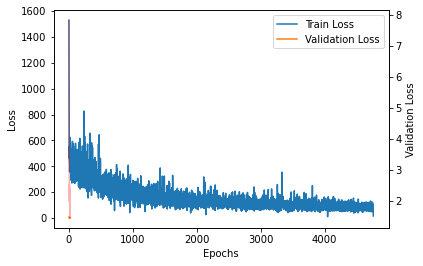

In [6]:
import matplotlib.pyplot as plt

# Plot dell'andamento della perdita
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Crea un secondo asse y per la perdita di addestramento
plt.twinx()
plt.plot(val_loss_list, 'r', alpha=0.3)  # Usiamo il colore rosso per la perdita di addestramento
plt.ylabel('Validation Loss')

plt.show()

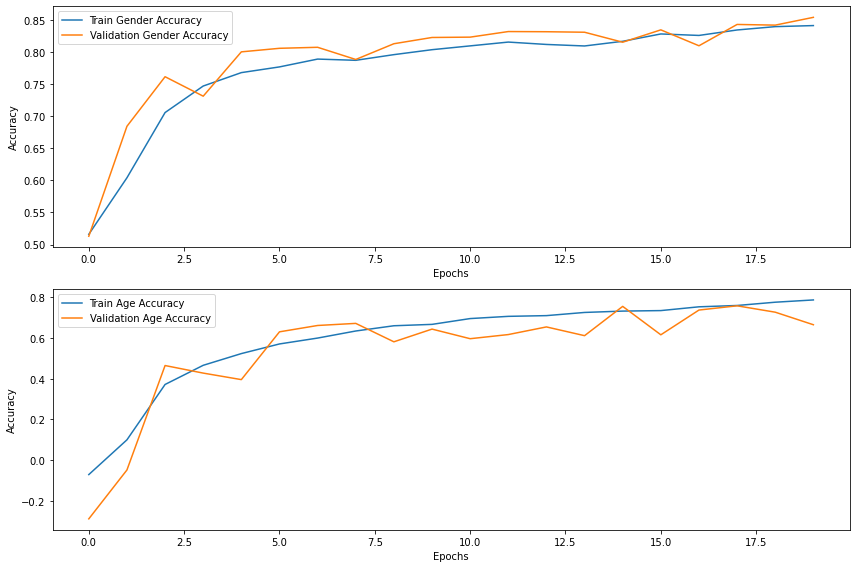

In [7]:
# Plot dell'andamento dell'accuratezza
plt.figure(figsize=(12, 8))

# Plot per il genere
plt.subplot(2, 1, 1)
plt.plot(train_gender_accuracy_list, label='Train Gender Accuracy')
plt.plot(val_gender_accuracy_list, label='Validation Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot per l'età
plt.subplot(2, 1, 2)
plt.plot(train_age_accuracy_list, label='Train Age Accuracy')
plt.plot(val_age_accuracy_list, label='Validation Age Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

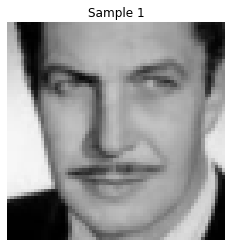

Real Age: [48.], Predicted Age: 24.96
Real Gender: Male, Predicted Gender: Male




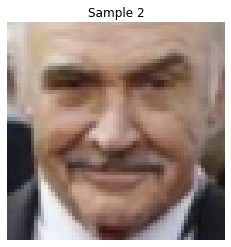

Real Age: [61.], Predicted Age: 64.43
Real Gender: Male, Predicted Gender: Male




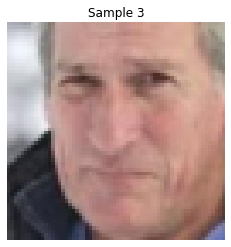

Real Age: [58.], Predicted Age: 39.67
Real Gender: Male, Predicted Gender: Male




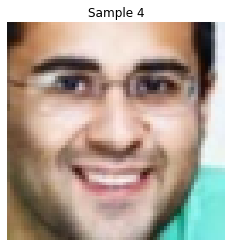

Real Age: [26.], Predicted Age: 23.58
Real Gender: Male, Predicted Gender: Male




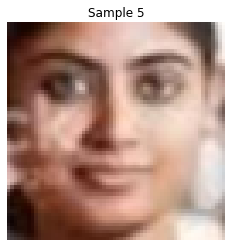

Real Age: [26.], Predicted Age: 19.14
Real Gender: Female, Predicted Gender: Female




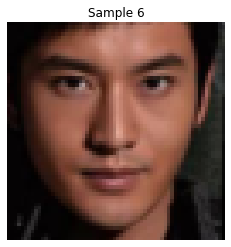

Real Age: [24.], Predicted Age: 20.37
Real Gender: Male, Predicted Gender: Male




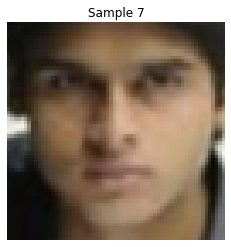

Real Age: [29.], Predicted Age: 22.34
Real Gender: Male, Predicted Gender: Male




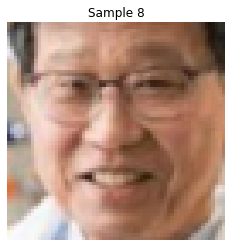

Real Age: [59.], Predicted Age: 39.82
Real Gender: Male, Predicted Gender: Male




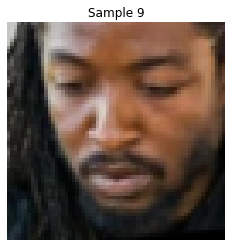

Real Age: [35.], Predicted Age: 28.87
Real Gender: Male, Predicted Gender: Male




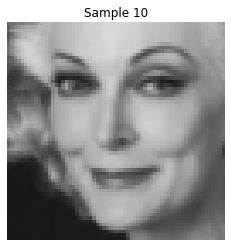

Real Age: [80.], Predicted Age: 35.01
Real Gender: Female, Predicted Gender: Female




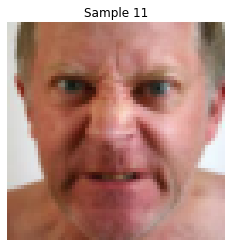

Real Age: [72.], Predicted Age: 45.73
Real Gender: Male, Predicted Gender: Male




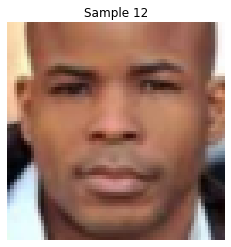

Real Age: [28.], Predicted Age: 25.66
Real Gender: Female, Predicted Gender: Male




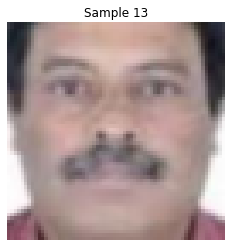

Real Age: [42.], Predicted Age: 36.76
Real Gender: Male, Predicted Gender: Male




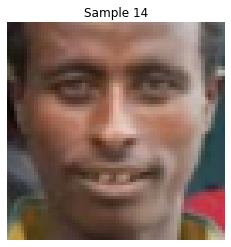

Real Age: [45.], Predicted Age: 28.74
Real Gender: Male, Predicted Gender: Male




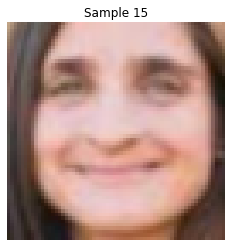

Real Age: [30.], Predicted Age: 26.71
Real Gender: Female, Predicted Gender: Female




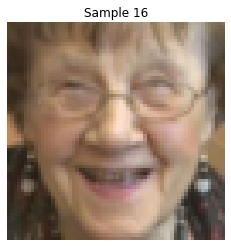

Real Age: [88.], Predicted Age: 68.52
Real Gender: Female, Predicted Gender: Male




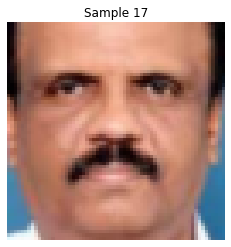

Real Age: [44.], Predicted Age: 46.81
Real Gender: Male, Predicted Gender: Male




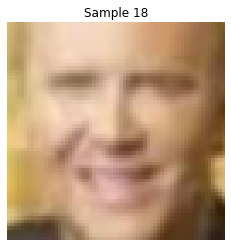

Real Age: [40.], Predicted Age: 33.21
Real Gender: Male, Predicted Gender: Male




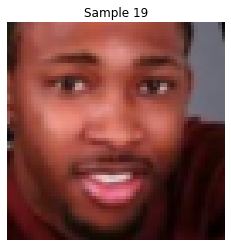

Real Age: [26.], Predicted Age: 20.34
Real Gender: Male, Predicted Gender: Female




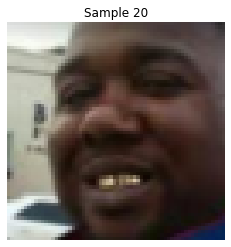

Real Age: [26.], Predicted Age: 37.29
Real Gender: Male, Predicted Gender: Male




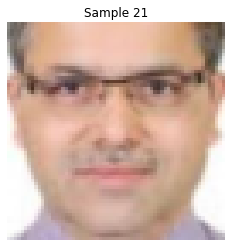

Real Age: [50.], Predicted Age: 31.49
Real Gender: Male, Predicted Gender: Male




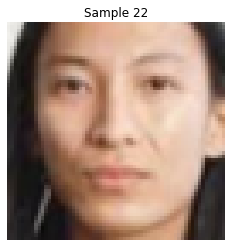

Real Age: [30.], Predicted Age: 28.63
Real Gender: Male, Predicted Gender: Female




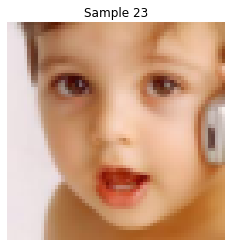

Real Age: [2.], Predicted Age: 1.72
Real Gender: Male, Predicted Gender: Female




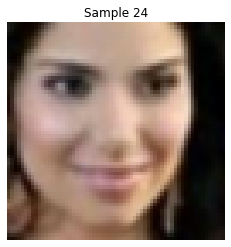

Real Age: [21.], Predicted Age: 19.65
Real Gender: Female, Predicted Gender: Female




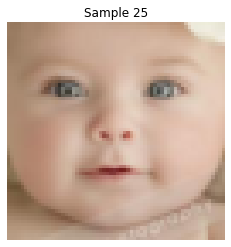

Real Age: [1.], Predicted Age: 0.90
Real Gender: Female, Predicted Gender: Female




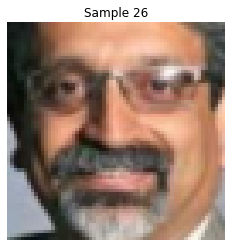

Real Age: [50.], Predicted Age: 49.14
Real Gender: Male, Predicted Gender: Male




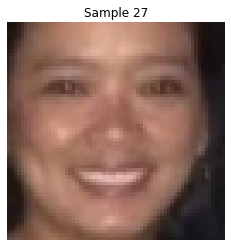

Real Age: [35.], Predicted Age: 25.35
Real Gender: Female, Predicted Gender: Female




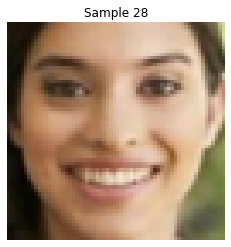

Real Age: [25.], Predicted Age: 17.90
Real Gender: Female, Predicted Gender: Female




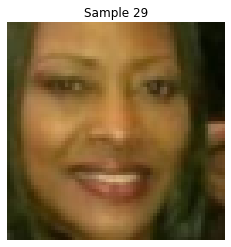

Real Age: [38.], Predicted Age: 31.42
Real Gender: Female, Predicted Gender: Female




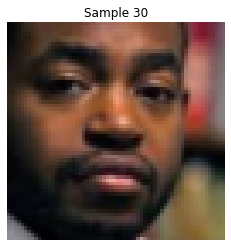

Real Age: [35.], Predicted Age: 25.91
Real Gender: Male, Predicted Gender: Male




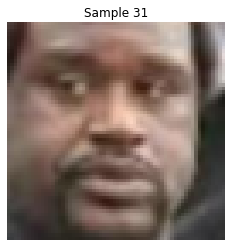

Real Age: [42.], Predicted Age: 27.75
Real Gender: Male, Predicted Gender: Male




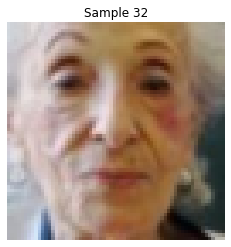

Real Age: [85.], Predicted Age: 83.73
Real Gender: Female, Predicted Gender: Male




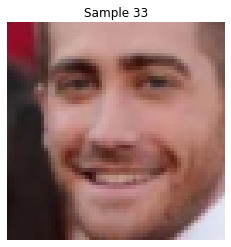

Real Age: [28.], Predicted Age: 29.63
Real Gender: Male, Predicted Gender: Male




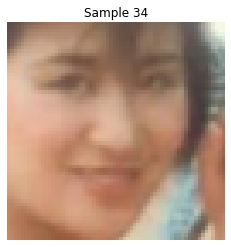

Real Age: [27.], Predicted Age: 20.84
Real Gender: Female, Predicted Gender: Female




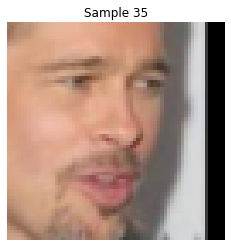

Real Age: [27.], Predicted Age: 26.38
Real Gender: Male, Predicted Gender: Male




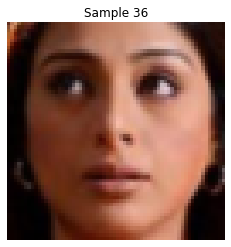

Real Age: [27.], Predicted Age: 21.82
Real Gender: Female, Predicted Gender: Female




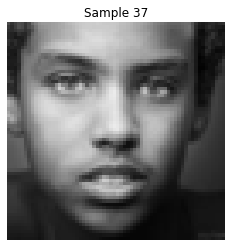

Real Age: [15.], Predicted Age: 21.46
Real Gender: Male, Predicted Gender: Male




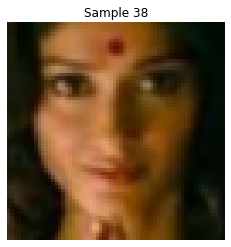

Real Age: [28.], Predicted Age: 20.81
Real Gender: Female, Predicted Gender: Female




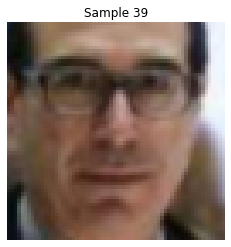

Real Age: [45.], Predicted Age: 34.08
Real Gender: Male, Predicted Gender: Male




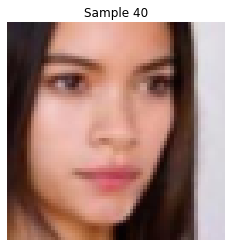

Real Age: [18.], Predicted Age: 18.77
Real Gender: Female, Predicted Gender: Female




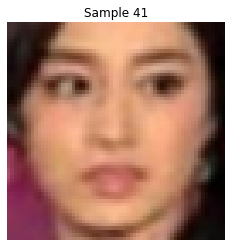

Real Age: [31.], Predicted Age: 19.16
Real Gender: Female, Predicted Gender: Female




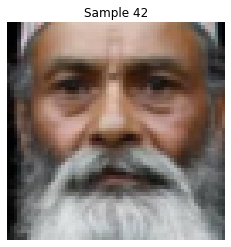

Real Age: [75.], Predicted Age: 71.44
Real Gender: Male, Predicted Gender: Male




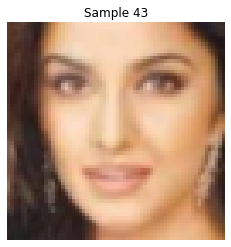

Real Age: [28.], Predicted Age: 23.62
Real Gender: Female, Predicted Gender: Female




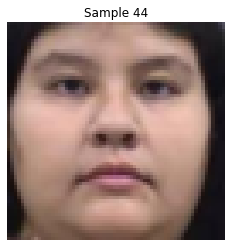

Real Age: [25.], Predicted Age: 24.38
Real Gender: Female, Predicted Gender: Male




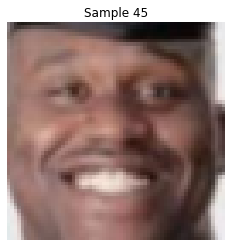

Real Age: [32.], Predicted Age: 37.46
Real Gender: Male, Predicted Gender: Male




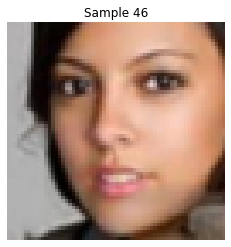

Real Age: [22.], Predicted Age: 18.46
Real Gender: Female, Predicted Gender: Female




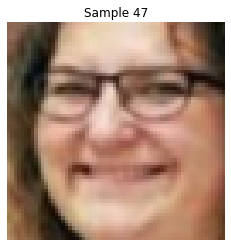

Real Age: [38.], Predicted Age: 30.95
Real Gender: Female, Predicted Gender: Female




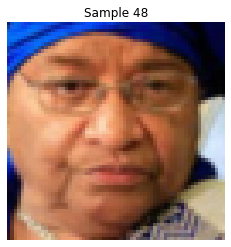

Real Age: [58.], Predicted Age: 58.52
Real Gender: Female, Predicted Gender: Female




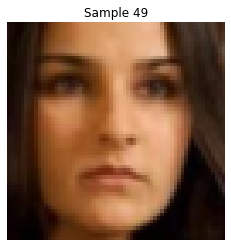

Real Age: [34.], Predicted Age: 24.82
Real Gender: Female, Predicted Gender: Female




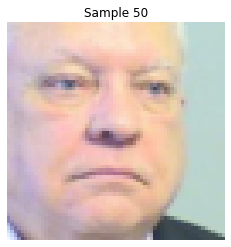

Real Age: [66.], Predicted Age: 51.77
Real Gender: Male, Predicted Gender: Male




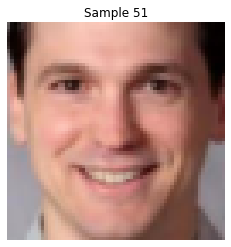

Real Age: [32.], Predicted Age: 23.30
Real Gender: Male, Predicted Gender: Male




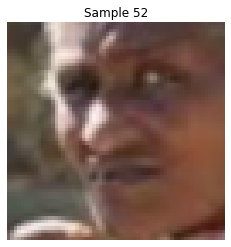

Real Age: [87.], Predicted Age: 47.82
Real Gender: Female, Predicted Gender: Male




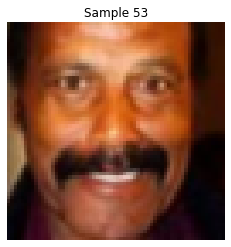

Real Age: [55.], Predicted Age: 47.03
Real Gender: Male, Predicted Gender: Male




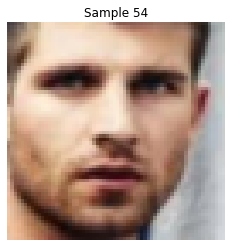

Real Age: [25.], Predicted Age: 22.78
Real Gender: Male, Predicted Gender: Male




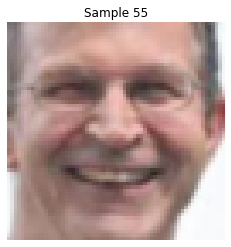

Real Age: [54.], Predicted Age: 49.40
Real Gender: Male, Predicted Gender: Male




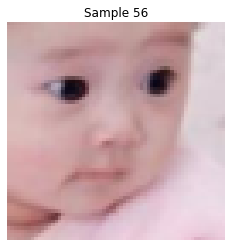

Real Age: [1.], Predicted Age: 1.37
Real Gender: Female, Predicted Gender: Female




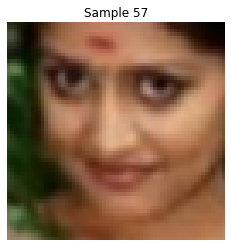

Real Age: [28.], Predicted Age: 24.92
Real Gender: Female, Predicted Gender: Female




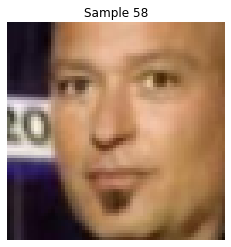

Real Age: [36.], Predicted Age: 26.95
Real Gender: Male, Predicted Gender: Female




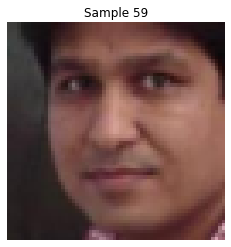

Real Age: [34.], Predicted Age: 27.95
Real Gender: Male, Predicted Gender: Male




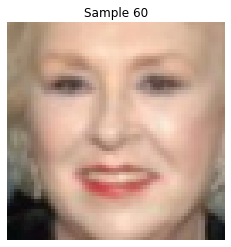

Real Age: [67.], Predicted Age: 52.57
Real Gender: Female, Predicted Gender: Female




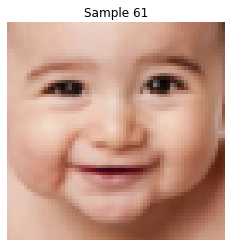

Real Age: [1.], Predicted Age: 1.46
Real Gender: Male, Predicted Gender: Female




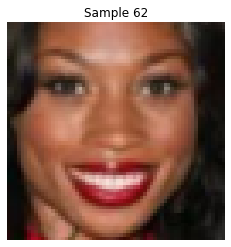

Real Age: [38.], Predicted Age: 24.53
Real Gender: Female, Predicted Gender: Female




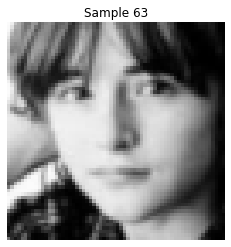

Real Age: [10.], Predicted Age: 23.65
Real Gender: Male, Predicted Gender: Female




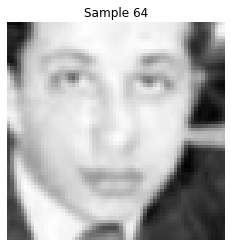

Real Age: [35.], Predicted Age: 30.18
Real Gender: Male, Predicted Gender: Female




In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Valuta il modello sul set di train
model.eval()
with torch.no_grad():
    for i, (inputs, gender_labels, age_labels) in enumerate(val_loader):
        age_labels = age_labels.float().view(-1, 1)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            gender_labels = gender_labels.cuda()
            age_labels = age_labels.cuda()
        gender_output, age_output = model(inputs)

        # Converte le predizioni in età e genere previsti
        predicted_age = age_output.cpu().numpy()
        predicted_gender = torch.argmax(gender_output, dim=1).cpu().numpy()

        # Età e genere reali
        real_age = age_labels.cpu().numpy()
        real_gender = gender_labels.cpu().numpy()

        # Stampa alcuni esempi
        if i % 100 == 0:
            for j in range(len(inputs)):
                # Visualizza l'immagine
                img = np.transpose(inputs[j].cpu().numpy(), (1, 2, 0))
                plt.imshow(img)
                plt.title(f"Sample {i * len(inputs) + j + 1}")
                plt.axis('off')
                plt.show()

                # Stampa età e genere reali e predetti
                print(f"Real Age: {real_age[j]}, Predicted Age: {predicted_age[j][0]:.2f}")
                print(f"Real Gender: {'Male' if real_gender[j] == 0 else 'Female'}, Predicted Gender: {'Male' if predicted_gender[j] == 0 else 'Female'}")
                print("\n")


Test Loss: 2.0907
Test Gender Accuracy: 0.8389, Test Age R2 Score: 0.6583


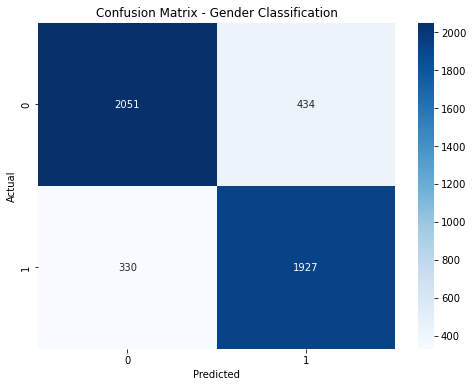

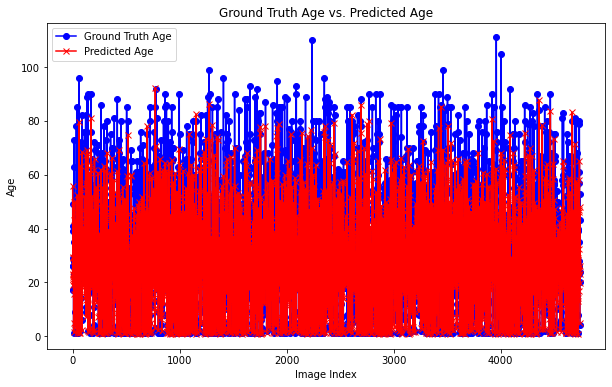

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

# ... (your existing code)

# Assuming you have a separate test_loader for the test set
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    correct_gender_test = 0
    total_test = 0
    test_age_r2 = 0
    
    test_loss_gender = 0.0
    test_loss_age = 0.0
    total_test_samples = 0

    all_predicted_genders = []
    all_true_genders = []

    all_true_ages = []
    all_predicted_ages = []

    for idx, (inputs, gender_labels, age_labels) in enumerate(test_loader):
        age_labels = age_labels.float().view(-1, 1)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            gender_labels = gender_labels.cuda()
            age_labels = age_labels.cuda()
        gender_output, age_output = model(inputs)

        # Sposta l'output alla stessa device di gender_labels
        gender_output = gender_output.to(gender_labels.device)
        age_output = age_output.to(age_labels.device)
        
        test_loss_gender += criterion_gender(gender_output, gender_labels).item()
        test_loss_age += criterion_age(age_output, age_labels).item()
        total_test_samples += len(inputs)

        # Calcola l'accuratezza per il genere
        _, predicted_gender = torch.max(gender_output, 1)
        correct_gender_test += (predicted_gender == gender_labels).sum().item()
        total_test += gender_labels.size(0)

        all_predicted_genders.extend(predicted_gender.cpu().numpy())
        all_true_genders.extend(gender_labels.cpu().numpy())

        # Calcola l'R2 score per l'età
        predicted_age = age_output.detach().cpu().numpy()
        test_age_r2 += r2_score(age_labels.cpu().numpy(), predicted_age)

        all_true_ages.extend(age_labels.cpu().numpy())
        all_predicted_ages.extend(predicted_age)

    test_gender_accuracy = correct_gender_test / total_test
    test_age_r2 /= len(test_loader)

    avg_test_loss_gender = test_loss_gender / total_test_samples
    avg_test_loss_age = test_loss_age / total_test_samples
    total_test_loss = avg_test_loss_gender + avg_test_loss_age

    print(f'Test Loss: {total_test_loss:.4f}')
    
    print(f'Test Gender Accuracy: {test_gender_accuracy:.4f}, '
          f'Test Age R2 Score: {test_age_r2:.4f}')

    # Plot the heatmap for the confusion matrix
    confusion_matrix = pd.crosstab(np.array(all_true_genders), np.array(all_predicted_genders), rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Gender Classification')
    plt.show()

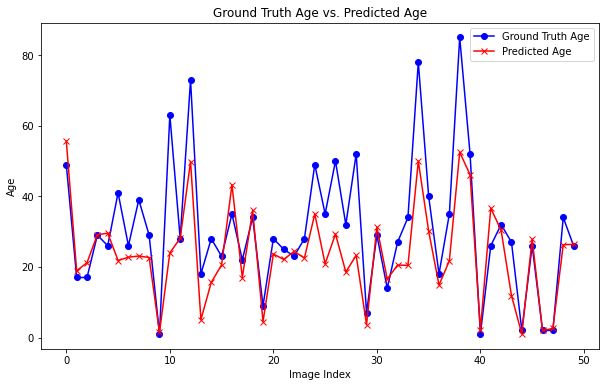

In [13]:

    # Plot the predicted age vs. ground truth age
    plt.figure(figsize=(10, 6))
    plt.plot(all_true_ages[0:50], label='Ground Truth Age', color='blue', marker='o')
    plt.plot(all_predicted_ages[0:50], label='Predicted Age', color='red', marker='x')
    plt.xlabel('Image Index')
    plt.ylabel('Age')
    plt.title('Ground Truth Age vs. Predicted Age')
    plt.legend()
    plt.show()